<a href="https://colab.research.google.com/github/Hsuyeon01/ESAA/blob/main/%EB%B6%84%EB%A5%98_(0905_%EA%B3%BC%EC%A0%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **3-1. MNIST**



In [1]:
from sklearn.datasets import fetch_openml

#as_frame 설정을 False로 해주면 기본값인 판다스 데이터프레임으로 파일을 받아 옴

mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들이 가지는 비슷한 딕셔너리 구조

- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키


In [2]:
X,y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

- 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음
- 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

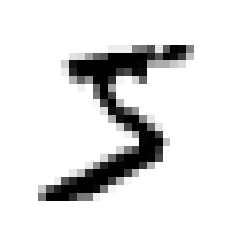

In [4]:
# 데이터셋에서 이미지 하나 확인
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
# 레이블은 문자열, y를 정수로 변환

import numpy as np
y=y.astype(np.uint8)

In [7]:
# 테스트 세트, 학습 세트 분리

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## **3-2. 이진분류기 훈련**



- '5-감지기' : '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 **이진분류기**의 한 예

In [8]:
# 분류 작업을 위해 타깃 벡터 만들기

y_train_5 = (y_train==5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

- 확률적 경사 하강법(SGD) 분류기 : 
    - 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가짐 -> 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문 

In [9]:
# SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# 모델을 이용해 숫자 5를 감지

sgd_clf.predict([some_digit])

array([ True])

-> 분류기는 이 이미지가 5를 나타낸다고 추측함

## **3-3. 성능 측정**

### 3-3-1) 교차 검증을 사용한 정확도 측정

교차 검증 구현

- 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요 -> 교차 검증 기능을 직접 구현하면 됨

In [11]:
# cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력하는 코드

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) # 데이터 복사 후 가져옴
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
  - 매 반복에서 분류기 객체를 복제하여 훈련폴드로 훈련시키고 테스트 폴드로 예측을 만듦
  - 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력

In [12]:
# cross_val_score 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDCLassifier 모델을 평가
# 나머지 폴드로 훈련시킨 모델을 사용

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

-> 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌 (특히 불균형한 데이터셋을 다룰 때)

### 3-3-2) 오차 행렬

오차 행렬

- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
- 테스트 세트로 예측을 만들 수 있지만 사용 X -> cross_val_predict() 함수 사용
- 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타냄

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환 (훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5  #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3-3-3) 정밀도와 재현율

정밀도 

- 양성 예측의 정확도 
- 정밀도 = TP / TP(진짜 양성의 수)+FP(거짓 양성의 수)
- 분류기가 다른 모든 양성 샘플을 무시하기 때문에 그리 유용하지 않음

재현율

- 분류기가 정확하게 감지한 양성 샘플의 비율
- 민감도 또는 진짜 양성 비율이라고도 함
- 재현율 = TP / TP+FN(거짓 음성의 수)

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 점수
- 정밀도와 재현율의 조화 평균
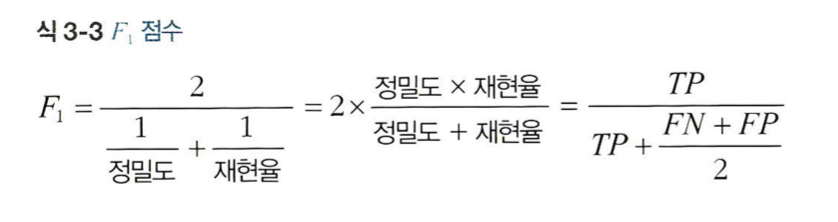

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음
- 정밀도/재현율 트레이드오프 : 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지

### 3-3-4) 정밀도/재현율 트레이드오프

- SGDClassifier 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산
  - 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당

In [21]:
# 분류기의 predict 메서드 대신 decision_function 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음
# 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
# 임곗값 0이므로 predict() 메서드와 같은 결과 반환

In [23]:
# 임곗값 높이기
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
# 훈련 세트에 있는 모든 샘플의 점수 구하기
# 예측 결과가 아니라 결정 점수를 반환하도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                             cv=3, method = 'decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, 
                                                         y_scores)

<function matplotlib.pyplot.show(*args, **kw)>

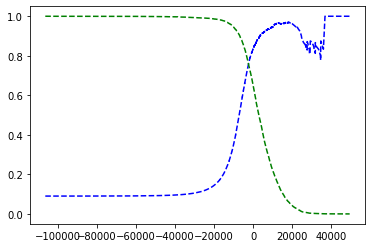

In [26]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1],'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

-> 재현율 그래프에서 정밀도가 급격하게 줄어드는 하강점 직전을 정밀도/재현율 트레이드 오프로 선택하는 것이 좋음

In [27]:
# 정밀도 90%를 달성하는 것이 목표

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

-> 충분히 큰 임곗값을 지정하면 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있음

### 3-3-5) ROC 곡선

수신기조작특성(ROC) 곡선 

- 정밀도/재현율 곡선과 비슷하지만 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
- FPR : 양성으로 잘못 분류된 음성 샘플의 비율, 1에서 진짜 음성 비율(TNR)을 뺀 값
- TNR : 특이도
- 민감도(재현율)에 대한 1-특이도 그래프

In [30]:
# 여러 임곗값에서 TPR과 FPR을 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

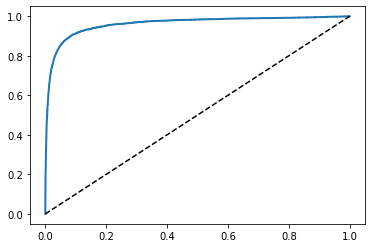

In [31]:
# 맷플롯립을 사용해 TPR에 대한 FPR 곡선 나타내기

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--') # 대각 점선

plot_roc_curve(fpr,tpr)
plt.show()

- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남
- 점선에서 멀리 떨어질수록 좋은 분류기
- 곡선 아래의 면적(AUC) : 분류기 비교에 사용, 완벽한 분류기는 ROC의 AUC가 1, 완전한 랜덤 분류기는 0.5

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

✏️ 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR(정밀도/재현율) 곡선을 사용하고 그렇지 않으면 ROC 곡선 사용

✏️ PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여줌

In [33]:
# RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 AUC 점수 비교
# RandomForestClassifier에서는 decision_function 대신 predict_proba 사용
# predict_proba는 샘플이 행, 클래스가 열, 샘플이 주어진 클래스에 속한 확률을 담은 배열 반환

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method = 'predict_proba')

In [34]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, 
                                                      y_scores_forest)

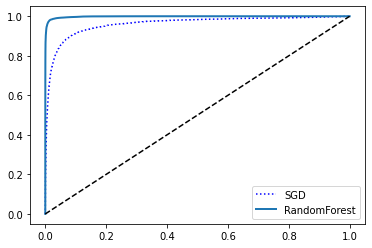

In [35]:
plt.plot(fpr, tpr, 'b:', label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc='lower right')
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

-> RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDCLassifier보다 좋아보임, ROC AUC 점수도 더 높음

## **3-4. 다중 분류**


다중 분류기 : 둘 이상의 클래스를 구별할 수 있음

OvR 전략

- 이진분류기 10개(0에서부터 9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있음 -> 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

OvO 전략

- 0과1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것
- 클래스가 N개라면 분류기는 Nx(N-1)/2개가 필요
- 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것

-> 대부분의 이진 분류 알고리즘에서는 OvR 선호

사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO 실행

In [37]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
# 가장 높은 점수가 클래스 5에 해당하는 값

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용

In [42]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [45]:
# SGDClassifier 훈련
# SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 OvR이나 OvO 적용 필요하지 않음
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [46]:
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
# SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, 
                scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [48]:
# 성능 높이기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,
                scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## **3-5. 에러 분석**



In [49]:
# 오차 행렬 살펴보기

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,
                                 cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

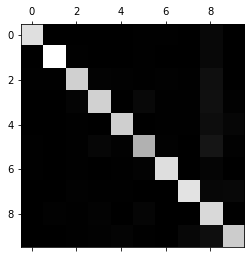

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

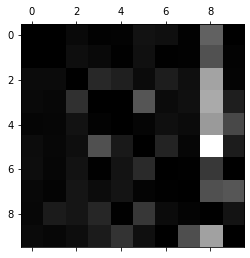

In [52]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

-> 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산, 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨
 
- 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는 것

## **3-6. 다중 레이블 분류**

다중 레이블 분류 : 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [54]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7) 
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] 
# 두 개의 타깃 레이블이 담김
# 두 개의 1차원 배열을 칼럼으로 세로로 붙여서 2차원 배열 만들기


knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) 

KNeighborsClassifier()

In [55]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [56]:
# 모든 레이블에 대한 F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, 
                                     y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

-> 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주려면 average='weighted'로 설정

## **3-7. 다중 출력 분류**

다중 출력 다중 클래스 분류 : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

In [57]:
# 이미지에서 잡음 제거
# randint() 함수를 사용하여 픽셀 강도에 잡음을 추가

noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [59]:
some_index = 0

In [60]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

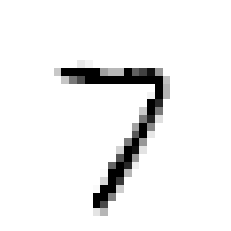

In [61]:
# 분류기를 훈련시켜 이 이미지를 깨끗하게 만듦

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)